In [1]:
import os
from symmer.symplectic.base import PauliwordOp
import json
import numpy as np
from ncon import ncon

In [2]:
def expand_local_basis(H):
    i, _ = H.shape
    i = int(np.log2(i))
    
    H_ = H.reshape([2]*(i*2))
    return H_

In [3]:
from functools import reduce
from operator import iconcat

def group_opposite_legs(H_exp):
    l = len(H_exp.shape)
    offset = int(l / 2)
    tlist = [[i, i+offset] for i in range(offset)]
    tlist = reduce(iconcat, tlist, [])
    return H_exp.transpose(tlist)
    

In [4]:
def mpo_decomp_step(H_curr, Dmax=8):
    l = len(H_curr.shape)
    a, i, j = H_curr.shape[:3]
    
    M = H_curr.reshape(a*i*j, -1)
    
    U, S, V = truncated_SVD(M, Dmax=Dmax)
    
    D = len(S)

    A = U.reshape(a, i, j, D)
    M = np.diag(S) @ V

    M = M.reshape(D, *[2]*(l-4), 1)
    return A, M

In [5]:
def truncated_SVD(M, Dmax=None):
    U, S, V = np.linalg.svd(M, full_matrices=False)
    
    if Dmax is not None and len(S) > Dmax:
        S = S[:Dmax]
        U = U[:, :Dmax]
        V = V[:Dmax, :]
    
    return U, S, V

In [6]:
def construct_MPO(H_local, Dmax=8, debug=False):
    l = int(len(H_local.shape) / 2) - 1
    As = []
    M = H_local
    for i in range(l-1):
        A, M = mpo_decomp_step(M, Dmax)
        if debug:
            print(i)
            print('  A shape: {}'.format(A.shape))
            print('  M shape: {}'.format(M.shape))
        As.append(A)
    if debug:
        print(i+1)
        print('  A shape: {}'.format(M.shape))
    As.append(M)
    #As[-1] = ncon([As[-1], M], ((-1, -2, -3, 1), (1, -4)))
    return As

In [7]:
test_dir = os.path.join(os.path.dirname(os.getcwd()), 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')

In [8]:
filename = 'H4_STO-3G_SINGLET_JW.json'

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

In [9]:
H_op = PauliwordOp.from_dictionary(data_dict['hamiltonian'])

In [10]:
# list(data_dict['hamiltonian'].keys())

### Constructing and MPO representation of H

In [11]:
H_sparse = H_op.to_sparse_matrix

In [12]:
H = H_sparse.toarray()

In [13]:
H_exp = expand_local_basis(H)

In [14]:
H_grouped = group_opposite_legs(H_exp)

In [15]:
H_grouped.shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [16]:
H_grouped = np.expand_dims(H_grouped, axis=(0, -1))

In [17]:
H_grouped.shape

(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)

In [18]:
As = construct_MPO(H_grouped, Dmax=16, debug=True)
As = [np.squeeze(A) for A in As]

0
  A shape: (1, 2, 2, 4)
  M shape: (4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
1
  A shape: (4, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
2
  A shape: (16, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)
3
  A shape: (16, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 2, 2, 2, 2, 1)
4
  A shape: (16, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 2, 2, 1)
5
  A shape: (16, 2, 2, 16)
  M shape: (16, 2, 2, 2, 2, 1)
6
  A shape: (16, 2, 2, 4)
  M shape: (4, 2, 2, 1)
7
  A shape: (4, 2, 2, 1)


### Groundstate Optimisation Using Quimb

In [19]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_dmrg import DMRG2

In [20]:
H_MPO = MatrixProductOperator(As, 'ldur')

In [21]:
print(H_MPO)

MatrixProductOperator([
    Tensor(shape=(4, 2, 2), inds=('_2e6f54AAAAA', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(4, 16, 2, 2), inds=('_2e6f54AAAAA', '_2e6f54AAAAB', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(16, 16, 2, 2), inds=('_2e6f54AAAAB', '_2e6f54AAAAC', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(16, 16, 2, 2), inds=('_2e6f54AAAAC', '_2e6f54AAAAD', 'k3', 'b3'), tags=oset(['I3'])),
    Tensor(shape=(16, 16, 2, 2), inds=('_2e6f54AAAAD', '_2e6f54AAAAE', 'k4', 'b4'), tags=oset(['I4'])),
    Tensor(shape=(16, 16, 2, 2), inds=('_2e6f54AAAAE', '_2e6f54AAAAF', 'k5', 'b5'), tags=oset(['I5'])),
    Tensor(shape=(16, 4, 2, 2), inds=('_2e6f54AAAAF', '_2e6f54AAAAG', 'k6', 'b6'), tags=oset(['I6'])),
    Tensor(shape=(4, 2, 2), inds=('_2e6f54AAAAG', 'k7', 'b7'), tags=oset(['I7'])),
], L=8, max_bond=16)


In [22]:
dmrg = DMRG2(H_MPO, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

In [23]:
dmrg.solve(verbosity=1, tol=1e-6)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|#############################################| 7/7 [00:00<00:00, 84.89it/s]

Energy: (-1.9046578661999116+1.5387566386190939e-06j) ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 248.97it/s]

Energy: (-1.9046623825473625+2.0632753937777255e-06j) ... not converged.
SWEEP-3, direction=R, max_bond=(10/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 275.79it/s]

Energy: (-1.904672144404971+2.3606137187399696e-06j) ... not converged.
SWEEP-4, direction=R, max_bond=(9/100), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 228.47it/s]

Energy: (-1.9046875650696258+3.225046813187804e-06j) ... not converged.
SWEEP-5, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 389.69it/s]

Energy: (-1.9047194587078653+4.776772859597239e-06j) ... not converged.
SWEEP-6, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 318.30it/s]

Energy: (-1.9062345152726003-3.3945434124715845e-06j) ... not converged.
SWEEP-7, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 118.10it/s]

Energy: (-1.9074034251063532+7.22549436837916e-07j) ... not converged.
SWEEP-8, direction=R, max_bond=(9/200), cutoff:1e-10



100%|############################################| 7/7 [00:00<00:00, 173.30it/s]

Energy: (-1.9074034096394072+6.225154554062584e-07j) ... converged!


True

In [25]:
energies = dmrg.energies

In [26]:
print(energies)

[(-1.9046578661999116+1.5387566386190939e-06j), (-1.9046623825473625+2.0632753937777255e-06j), (-1.904672144404971+2.3606137187399696e-06j), (-1.9046875650696258+3.225046813187804e-06j), (-1.9047194587078653+4.776772859597239e-06j), (-1.9062345152726003-3.3945434124715845e-06j), (-1.9074034251063532+7.22549436837916e-07j), (-1.9074034096394072+6.225154554062584e-07j)]


In [27]:
import matplotlib.pyplot as plt

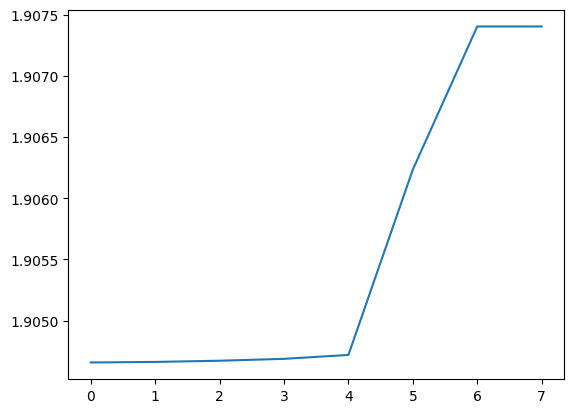

In [28]:
plt.plot(np.abs(energies))

In [30]:
dmrg.state.show()

 2 4 8 9 8 4 2 
>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │


### Test MPO Quimb with built in Ising Hamiltonian

In [16]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_gen import MPO_ham_ising
from quimb.tensor.tensor_dmrg import DMRG2
from quimb.tensor.tensor_gen import SpinHam1D

In [17]:
def Ham_Ising(j=1.0, bx=0.0, S=1/2, cyclic=False):
    H = SpinHam1D(S=S, cyclic=cyclic)
    H += j, 'Z', 'Z'
    H -= bx, 'X'
    return H

In [18]:
mpo_ising = MPO_ham_ising(L = 4, bx=0.0)

In [19]:
print(mpo_ising)

MatrixProductOperator([
    Tensor(shape=(3, 2, 2), inds=('_aba634AAAAV', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(3, 3, 2, 2), inds=('_aba634AAAAV', '_aba634AAAAW', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(3, 3, 2, 2), inds=('_aba634AAAAW', '_aba634AAAAX', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(3, 2, 2), inds=('_aba634AAAAX', 'k3', 'b3'), tags=oset(['I3'])),
], L=4, max_bond=3)


In [20]:
dmrg = DMRG2(mpo_ising, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

In [21]:
dmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|############################################| 3/3 [00:00<00:00, 706.98it/s]

Energy: -0.7499999999999997 ... not converged.
SWEEP-2, direction=R, max_bond=(2/20), cutoff:1e-10



100%|############################################| 3/3 [00:00<00:00, 746.18it/s]

Energy: -0.75 ... converged!


True

In [22]:
dmrg.state.show(max_width=80)

 1 1 1 
>─>─>─<
│ │ │ │


In [23]:
matrix_ising = Ham_Ising().build_sparse(4)
matrix_ising = matrix_ising.toarray()

In [27]:
matrix_exp = expand_local_basis(matrix_ising)
matrix_grouped = group_opposite_legs(matrix_exp)
matrix_grouped = np.expand_dims(matrix_grouped, axis=(0, -1))
As = construct_MPO(matrix_grouped, Dmax=16, debug=False)
As = [np.squeeze(A) for A in As]
my_MPO = MatrixProductOperator(As, 'ldur')

In [28]:
print(my_MPO)

MatrixProductOperator([
    Tensor(shape=(4, 2, 2), inds=('_aba634AAAAu', 'k0', 'b0'), tags=oset(['I0'])),
    Tensor(shape=(4, 16, 2, 2), inds=('_aba634AAAAu', '_aba634AAAAv', 'k1', 'b1'), tags=oset(['I1'])),
    Tensor(shape=(16, 4, 2, 2), inds=('_aba634AAAAv', '_aba634AAAAw', 'k2', 'b2'), tags=oset(['I2'])),
    Tensor(shape=(4, 2, 2), inds=('_aba634AAAAw', 'k3', 'b3'), tags=oset(['I3'])),
], L=4, max_bond=16)


In [29]:
mydmrg = DMRG2(my_MPO, bond_dims=10, cutoffs=1e-10)

In [30]:
mydmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|#############################################| 3/3 [00:00<00:00, 95.52it/s]

Energy: (-0.7499999999999997+0j) ... not converged.
SWEEP-2, direction=R, max_bond=(2/10), cutoff:1e-10



100%|############################################| 3/3 [00:00<00:00, 308.83it/s]

Energy: (-0.75+0j) ... converged!


True

In [46]:
import quimb

In [47]:
print(quimb.__version__)

1.4.0
